In [1]:
import math
import random
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad = (other * (self.data ** (other-1))) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), "ReLU")

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1 )
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        
        return out
        

    def backward(self):
        nodes = []
        visited = set()

        def build_topology(node):
            if node not in visited:
                visited.add(node)
                
                for child in node._prev:
                    build_topology(child)
                nodes.append(node)

        build_topology(self)

        self.grad = 1
        for node in reversed(nodes):
            node._backward()

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        other + (-self)

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"(data={self.data},grad={self.grad})"

In [3]:
class Neuron:
    def __init__(self, num_of_input, non_lin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_of_input)]
        self.b = Value(0)
        self.non_lin = non_lin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        
        return act.tanh() if self.non_lin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"Neuron {len(self.w)}"

class Layer:
    def __init__(self, num_of_input, num_of_output, **kwargs):
        self.neurons = [Neuron(num_of_input, **kwargs) for _ in range (num_of_output)]

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:
    def __init__(self, num_of_inputs, num_of_outputs):
        all_layers_info = [num_of_inputs] + num_of_outputs
        len_all_layers = len(all_layers_info)
        self.layers = []

        for i in range(len_all_layers - 1):
            isLastLayer = i == len_all_layers - 2
            newLayer = Layer(all_layers_info[i], all_layers_info[i+1], non_lin= not isLastLayer)
            self.layers.append(newLayer)

    def __call__(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)

        return out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for parameter in self.parameters():
            parameter.grad = 0

In [4]:
def trace(root):
    nodes, edges = set(), set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for children in node._prev:
                edges.add((children, node))
                build(children)

    build(root)
    
    return nodes, edges

def draw_graph(root, format="svg", rankdir="LR"):
    nodes, edges = trace(root)
    graph = Digraph(format=format, graph_attr={"rankdir": rankdir})

    for node in nodes:
        graph.node(name=str(id(node)), label="{ data %.4f | grad %.4f }" % (node.data, node.grad), shape="record")
        if node._op:
            operand_node_id = str(id(node)) + node._op
            graph.node(name=operand_node_id, label=node._op)
            graph.edge(operand_node_id, str(id(node)))
        
    for n1, n2 in edges:
        graph.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return graph

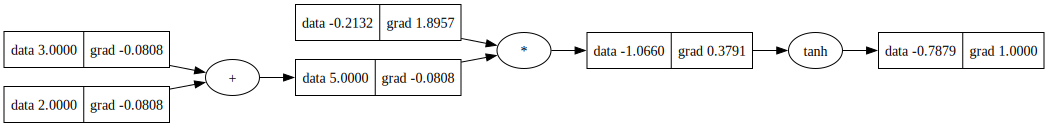

In [5]:
a = Value(2)
b = Value(3)
c = a + b
d = Value(-0.2132)
e = c * d
f = e.tanh()
f.backward()
graph = draw_graph(f)
graph

In [43]:
model = MLP(2, [8, 4, 1])

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=150, noise=0.4)

In [44]:
num_of_iterations = 100
loss_history = []
for i in range(num_of_iterations):
    # predictions = [model(inp) for inp in X]
    predictions = list(map(model, X))
    
    losses = [((pred-y_org)**2).tanh() for pred,y_org in zip(predictions, y)]
    loss = sum(losses) * (1.0 / len(losses))
    
    model.zero_grad()
    loss.backward()

    print(f"iteration: {i+1} loss: {loss.data}")
    loss_history.append(loss.data)
    # learning_rate = 1.0 - 0.9*i/num_of_iterations
    learning_rate = 0.1

    for param in model.parameters():
        param.data -= learning_rate * param.grad

iteration: 1 loss: 0.6219998893817503
iteration: 2 loss: 0.45207869772691445
iteration: 3 loss: 0.28688033237477284
iteration: 4 loss: 0.20932122279163906
iteration: 5 loss: 0.1845404219701281
iteration: 6 loss: 0.17231424801208647
iteration: 7 loss: 0.1648934883250201
iteration: 8 loss: 0.1600936563761978
iteration: 9 loss: 0.15681758509353141
iteration: 10 loss: 0.15444819776534302
iteration: 11 loss: 0.15263069865540327
iteration: 12 loss: 0.15115776927448163
iteration: 13 loss: 0.14990632428444176
iteration: 14 loss: 0.14880218111927634
iteration: 15 loss: 0.14779998143953038
iteration: 16 loss: 0.1468715778260971
iteration: 17 loss: 0.14599921202343466
iteration: 18 loss: 0.14517145661814926
iteration: 19 loss: 0.1443807760555182
iteration: 20 loss: 0.14362204882152838
iteration: 21 loss: 0.14289166593217031
iteration: 22 loss: 0.1421869777340262
iteration: 23 loss: 0.14150595255616763
iteration: 24 loss: 0.1408469648810563
iteration: 25 loss: 0.14020866304442547
iteration: 26 los

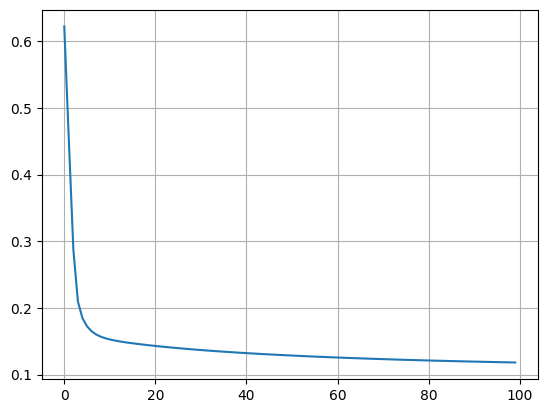

In [45]:
plt.plot(loss_history)
plt.grid()
plt.savefig("static/loss.png")

In [42]:
predictions = [model(inp) for inp in X]
total_right_answers = 0
for i in zip(predictions, y):
    pred = 1 if i[0].data > 0.5 else 0
    
    if pred == i[1]:
        total_right_answers += 1

In [38]:
# Visualize how learning rates decrease with increase in operations
# for k in range(num_of_iterations):
#     learning_rate = 1.0 - 0.9*k/num_of_iterations
#     print(f"Learning rate: {learning_rate}")

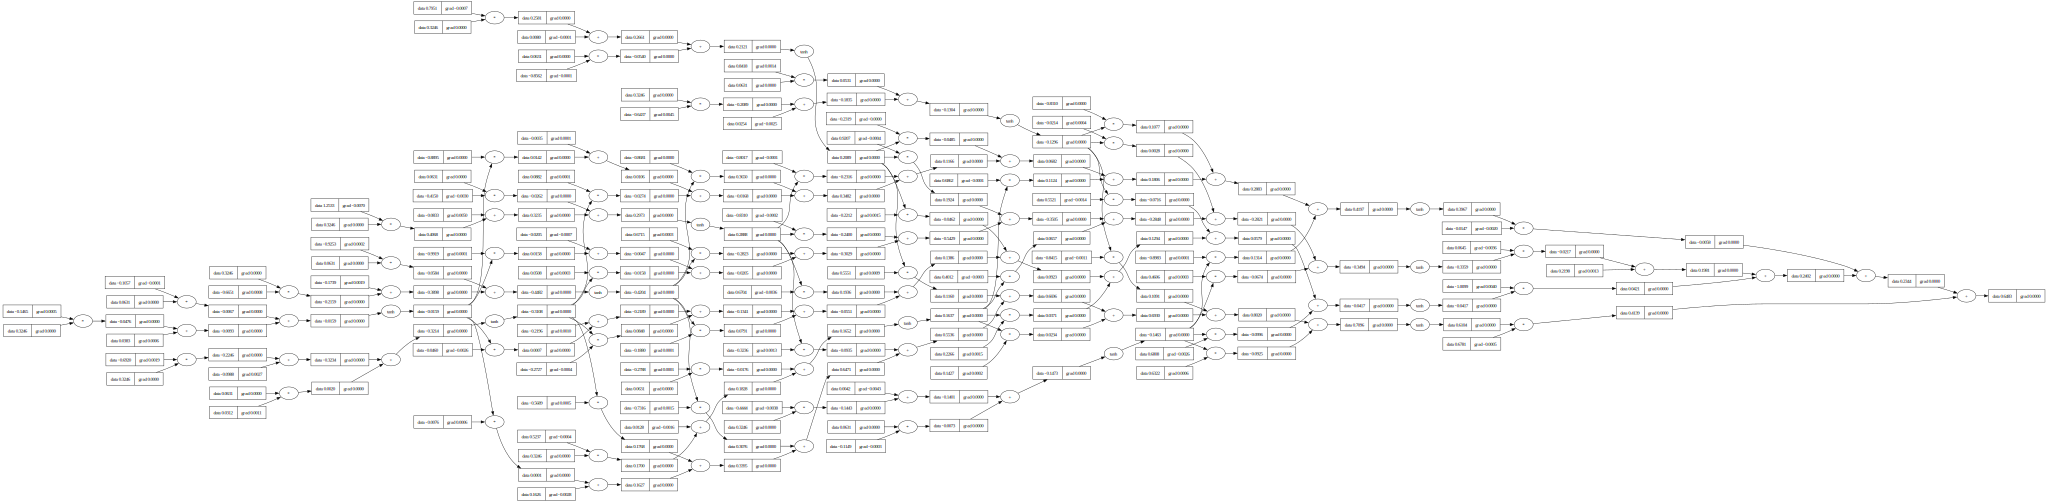

In [12]:
temp = model(X[0])
graph = draw_graph(temp)
graph.render(filename="model-graph", directory="static")
graph